## Edges Data

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

threshold = 3
cutoff = 8

In [2]:
edges = pd.read_csv(f'edges_v5.csv',
                    low_memory=False, 
                    encoding='utf-8',
                    float_precision='round_trip')

In [3]:
edges.head()

,Empl Id,Event Effective Date,seq_id,position_from_upd,position_to_upd,transition_days
0,423,2008-06-02,2.0,job_mktcqqmd,job_imotmicq,0
1,423,2008-12-19,3.0,job_imotmicq,job_mktcqqmd,0
2,423,2011-02-08,4.0,job_mktcqqmd,job_xszhflnn,0
3,464,2010-09-27,1.0,job_vbuuolrp,job_durplfwg,0
4,496,2006-11-21,1.0,job_jdvtasgd,job_wonsaohh,0


In [4]:
edges = edges[edges['position_from_upd'] != edges['position_to_upd']]

In [5]:
edges.shape

(9196, 6)

## Build the Transition Matrix of Probabilities is given
### - on rows we have current state
### - on columns we have new state

## Replace space with "_"

In [6]:
edges['position_from_upd'] = edges['position_from_upd'].str.replace(" ", "_")
edges['position_to_upd'] = edges['position_to_upd'].str.replace(" ", "_")

In [7]:
edges_agg = edges.groupby(['position_from_upd','position_to_upd'])['Empl Id'].count()
# select only transitions that occured "x" number of times
edges_agg = edges_agg[edges_agg >= threshold]
edges_agg.shape

(607,)

In [8]:
edges_agg.sort_values(ascending = False).head(10)

position_from_upd  position_to_upd
job_ritctbot       job_zfdhxwgu       160
job_mzavdsfx       job_klnfannp       105
                   job_uoxjypzo       100
job_pcauujtm       job_jwpjtvmy        88
job_uoxjypzo       job_qffxgkda        80
job_mzavdsfx       job_ekneewel        74
job_jwpjtvmy       job_vxigvurt        74
job_mzavdsfx       job_ygrvlvoe        66
job_kaoazett       job_tizgfumb        65
job_klnfannp       job_uoxjypzo        59
Name: Empl Id, dtype: int64

## Average number of positions per employee

In [9]:
edges.groupby('Empl Id')['position_from_upd'].nunique().mean()

1.9330316742081448

<Axes: >

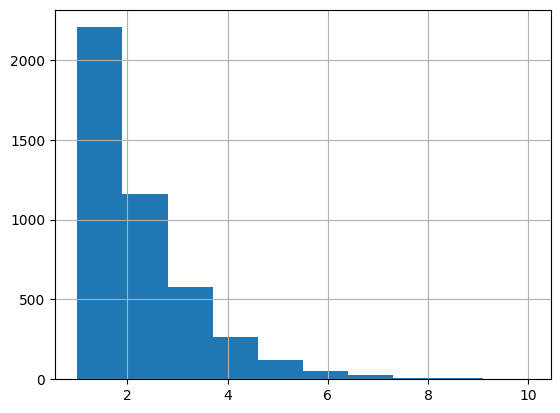

In [10]:
edges.groupby('Empl Id')['position_from_upd'].nunique().hist()

## Create states

In [11]:
allstates = set(edges_agg.index.get_level_values(0)).union(set(edges_agg.index.get_level_values(1)))
n = len(allstates)
print("n=",n)
states = list(allstates)

n= 287


## Create transition probability matrix

In [12]:
# init with 0
tpm = [[0 for i in range(n)] for j in range(n)]
# populate with nij = number of transition from i to j
for i,source in enumerate(allstates):
    if i % 100 == 0:
        print(i, source)
    for j,dest in enumerate(allstates):
        if i != j:
            try:
                hrcnt = edges_agg.loc[(source, dest)]
                tpm[i][j] = hrcnt
            except:
                pass;
        else:
            tpm[i][j] = 0

0 job_cgnnuwtb
100 job_mnfaevca
200 job_rlxipsws


In [13]:
p = [[0 for i in range(n)] for j in range(n)]
for i in range(n):
    i_sum = 0
    for j in range(n):
        i_sum = i_sum + tpm[i][j]
    if i_sum > 0:
        for j in range(n):
            p[i][j] = tpm[i][j]/i_sum
    else:
        p[i][i] = 1

In [14]:
for i in range(n):
    if round(sum(p[i])) != 1:
        print(i, sum(p[i]), "Somewhere, something went wrong.")

In [15]:
len(p), len(p[0])

(287, 287)

## Remove rows and cols with 0

In [16]:
pa = np.array(p)
dim = len(pa[0])
pa.shape, dim

((287, 287), 287)

In [17]:
len(pa[1,:]), len(pa[:,1])

(287, 287)

In [18]:
for i in range(len(p)):
    if sum(pa[i,:]) == 0:
        if sum(pa[:,i]) == 0:
            print(i)

## Build the graph with:
### 1 - vertex = states
### 2- edges weight = -log(p(i,j)

In [19]:
import networkx as nx  # For the magic
import pydot
import matplotlib.pyplot as plt  # For plotting

In [20]:
p_arr = np.array(p)
p_arr.shape

(287, 287)

## Transition probability matrux: replace zeros with min

In [21]:
def replaceZeroes(data):
    min_nonzero = np.min(data[np.nonzero(data)])
    data[data == 0] = min_nonzero
    return data

p_arr = replaceZeroes(p_arr)
np.min(p_arr)

0.004918032786885246

In [22]:
G = nx.DiGraph()

for i, origin_state in enumerate(states):
    for j, destination_state in enumerate(states):
        if i!=j:
            cost = -np.log(p_arr[i][j])
            if cost < 0:
                print(origin_state, destination_state, p[i][j])                
            if p[i][j] > 0:          
                G.add_edge(origin_state,
                           destination_state,
                           weight = cost,
                           prob = p[i][j],
                           hrcnt = tpm[i][j]
                          )
                
prob = [(e[2]['prob']) for e in G.edges(data=True)]                

## Draw subgraph

In [23]:
def show_graph(g, source, target):
    dot_graph = nx.nx_pydot.to_pydot(g)
    shortest_path = nx.shortest_path(g, source=source, target=target, weight='weight', method='dijkstra')
    
    for node in dot_graph.get_nodes():
        lbl_node = node.get_name().replace('\"','')
        node.set_style('"rounded,filled", fixedsize="true", width="2", color="#ABD5E3",fontcolor="black",fontsize="10"')

        if lbl_node in shortest_path:
            node.set_style('"rounded,filled",fixedsize="true", width="2", color="#F63366",fontcolor="white",fontsize="10"')

    total_weight = sum([x[2]['hrcnt'] for x in g.edges(data=True)])

    for edge in dot_graph.get_edges():
        # print(edge)
        w = edge.get_attributes()['weight']
        p = edge.get_attributes()['prob']
        hrc = edge.get_attributes()['hrcnt']
        
        source = edge.get_source().replace('\"','')
        destination = edge.get_destination().replace('\"','')
        
        edge.set_penwidth(0.2 + 50 * int(hrc)/total_weight)
        if source in shortest_path and \
            destination in shortest_path and \
            abs(shortest_path.index(source)-shortest_path.index(destination)) == 1:
            edge.set_color('#F63366')
        else:
            edge.set_color('grey')

        edge.set_tooltip(edge.get_source() + ' -> '
                         + edge.get_destination() + '\n'
                         + 'cost to minimize: ' + str(w) + ', prob: ' + str(p) + ', hrcnt=' + str(hrc))

    dot_graph.set_graph_defaults(
#         size="\"25,25\"",
        # height=10,
        ratio='auto',
        # fontname='Courier',
        fontsize='12',
        compound=True,
        splines='curve',
        layout='dot',
        bgcolor='#0E1117',
    )

    return dot_graph, shortest_path

In [24]:
from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

In [25]:
def viz_paths(G, state_from, state_to, filename):
    paths = list(nx.all_simple_paths(G, state_from, state_to, cutoff=cutoff))
    sg = nx.DiGraph()
    for r in paths:
#         route_edges = [(r[n], r[n + 1], edges_agg.loc[(r[n], r[n + 1])]) for n in range(len(r) - 1)]
        route_edges = [(r[n], r[n + 1], G.get_edge_data(r[n], r[n + 1])['weight']) for n in range(len(r) - 1)]
        sg.add_weighted_edges_from(route_edges)
        
    for node1, node2, data in sg.edges.data():
        data['prob'] = G.get_edge_data(node1, node2)['prob']
        data['hrcnt'] = G.get_edge_data(node1, node2)['hrcnt']
    
    graph, shortest = show_graph(sg, state_from, state_to)
    view_pydot(graph)
    graph.write_svg(filename + '.svg')
    print('Optimal path', shortest)

## Calculate the shortest (ie. most probable path) between two states

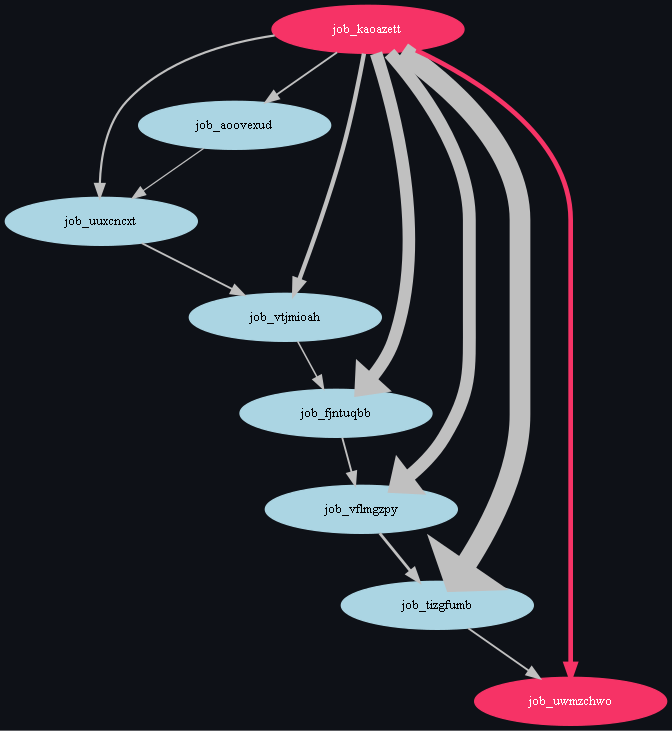

Optimal path ['job_kaoazett', 'job_uwmzchwo']


In [26]:
state_from = "job_kaoazett"
state_to = "job_uwmzchwo"
viz_paths(G, state_from, state_to, f'shortest path between {state_from} and {state_to}')

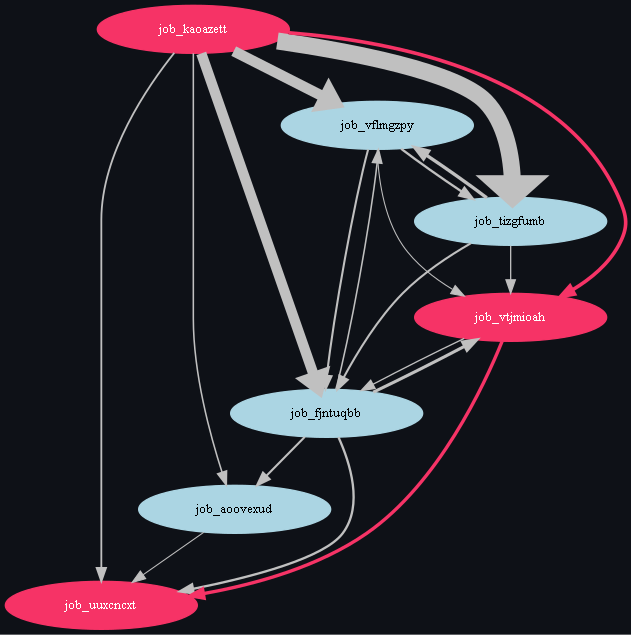

Optimal path ['job_kaoazett', 'job_vtjmioah', 'job_uuxcncxt']


6

In [27]:
state_from = 'job_kaoazett'
state_to = 'job_uuxcncxt'
viz_paths(G, state_from, state_to, f'shortest path between {state_from} and {state_to}')
edges_agg.loc[(state_from, state_to)]

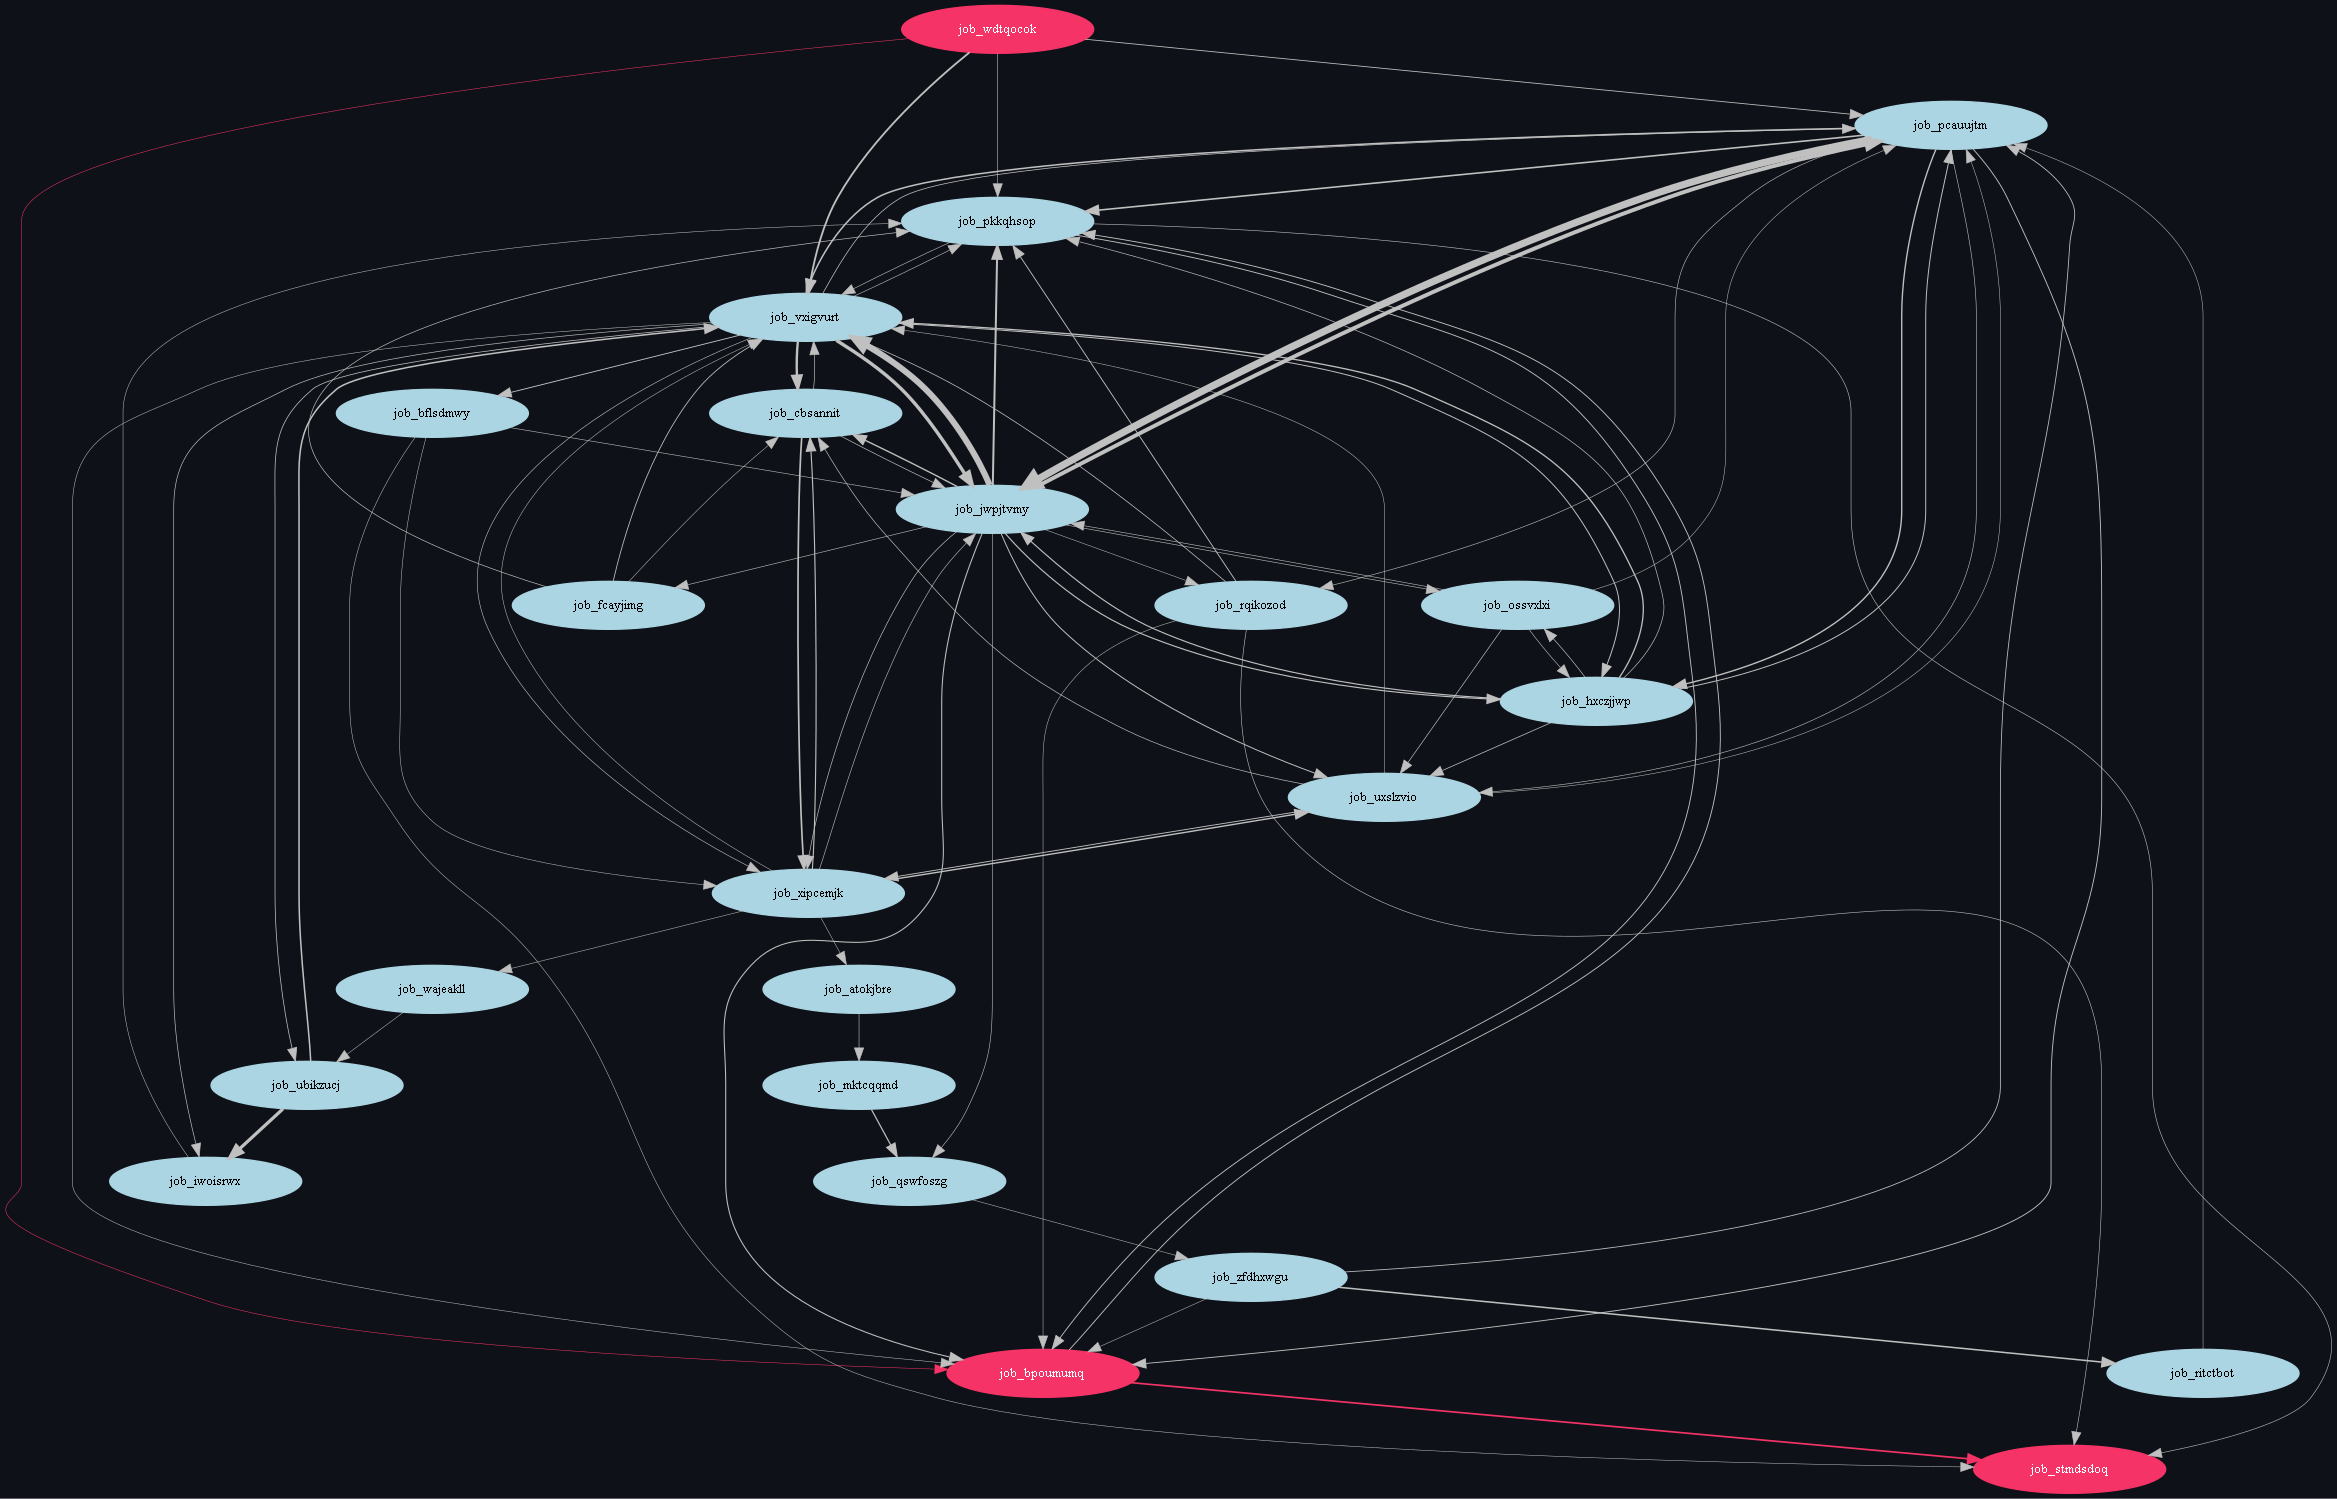

Optimal path ['job_wdtqocok', 'job_bpoumumq', 'job_stmdsdoq']


In [28]:
state_from = 'job_wdtqocok'
state_to = 'job_stmdsdoq'
viz_paths(G, state_from, state_to, f'shortest path between {state_from} and {state_to}')

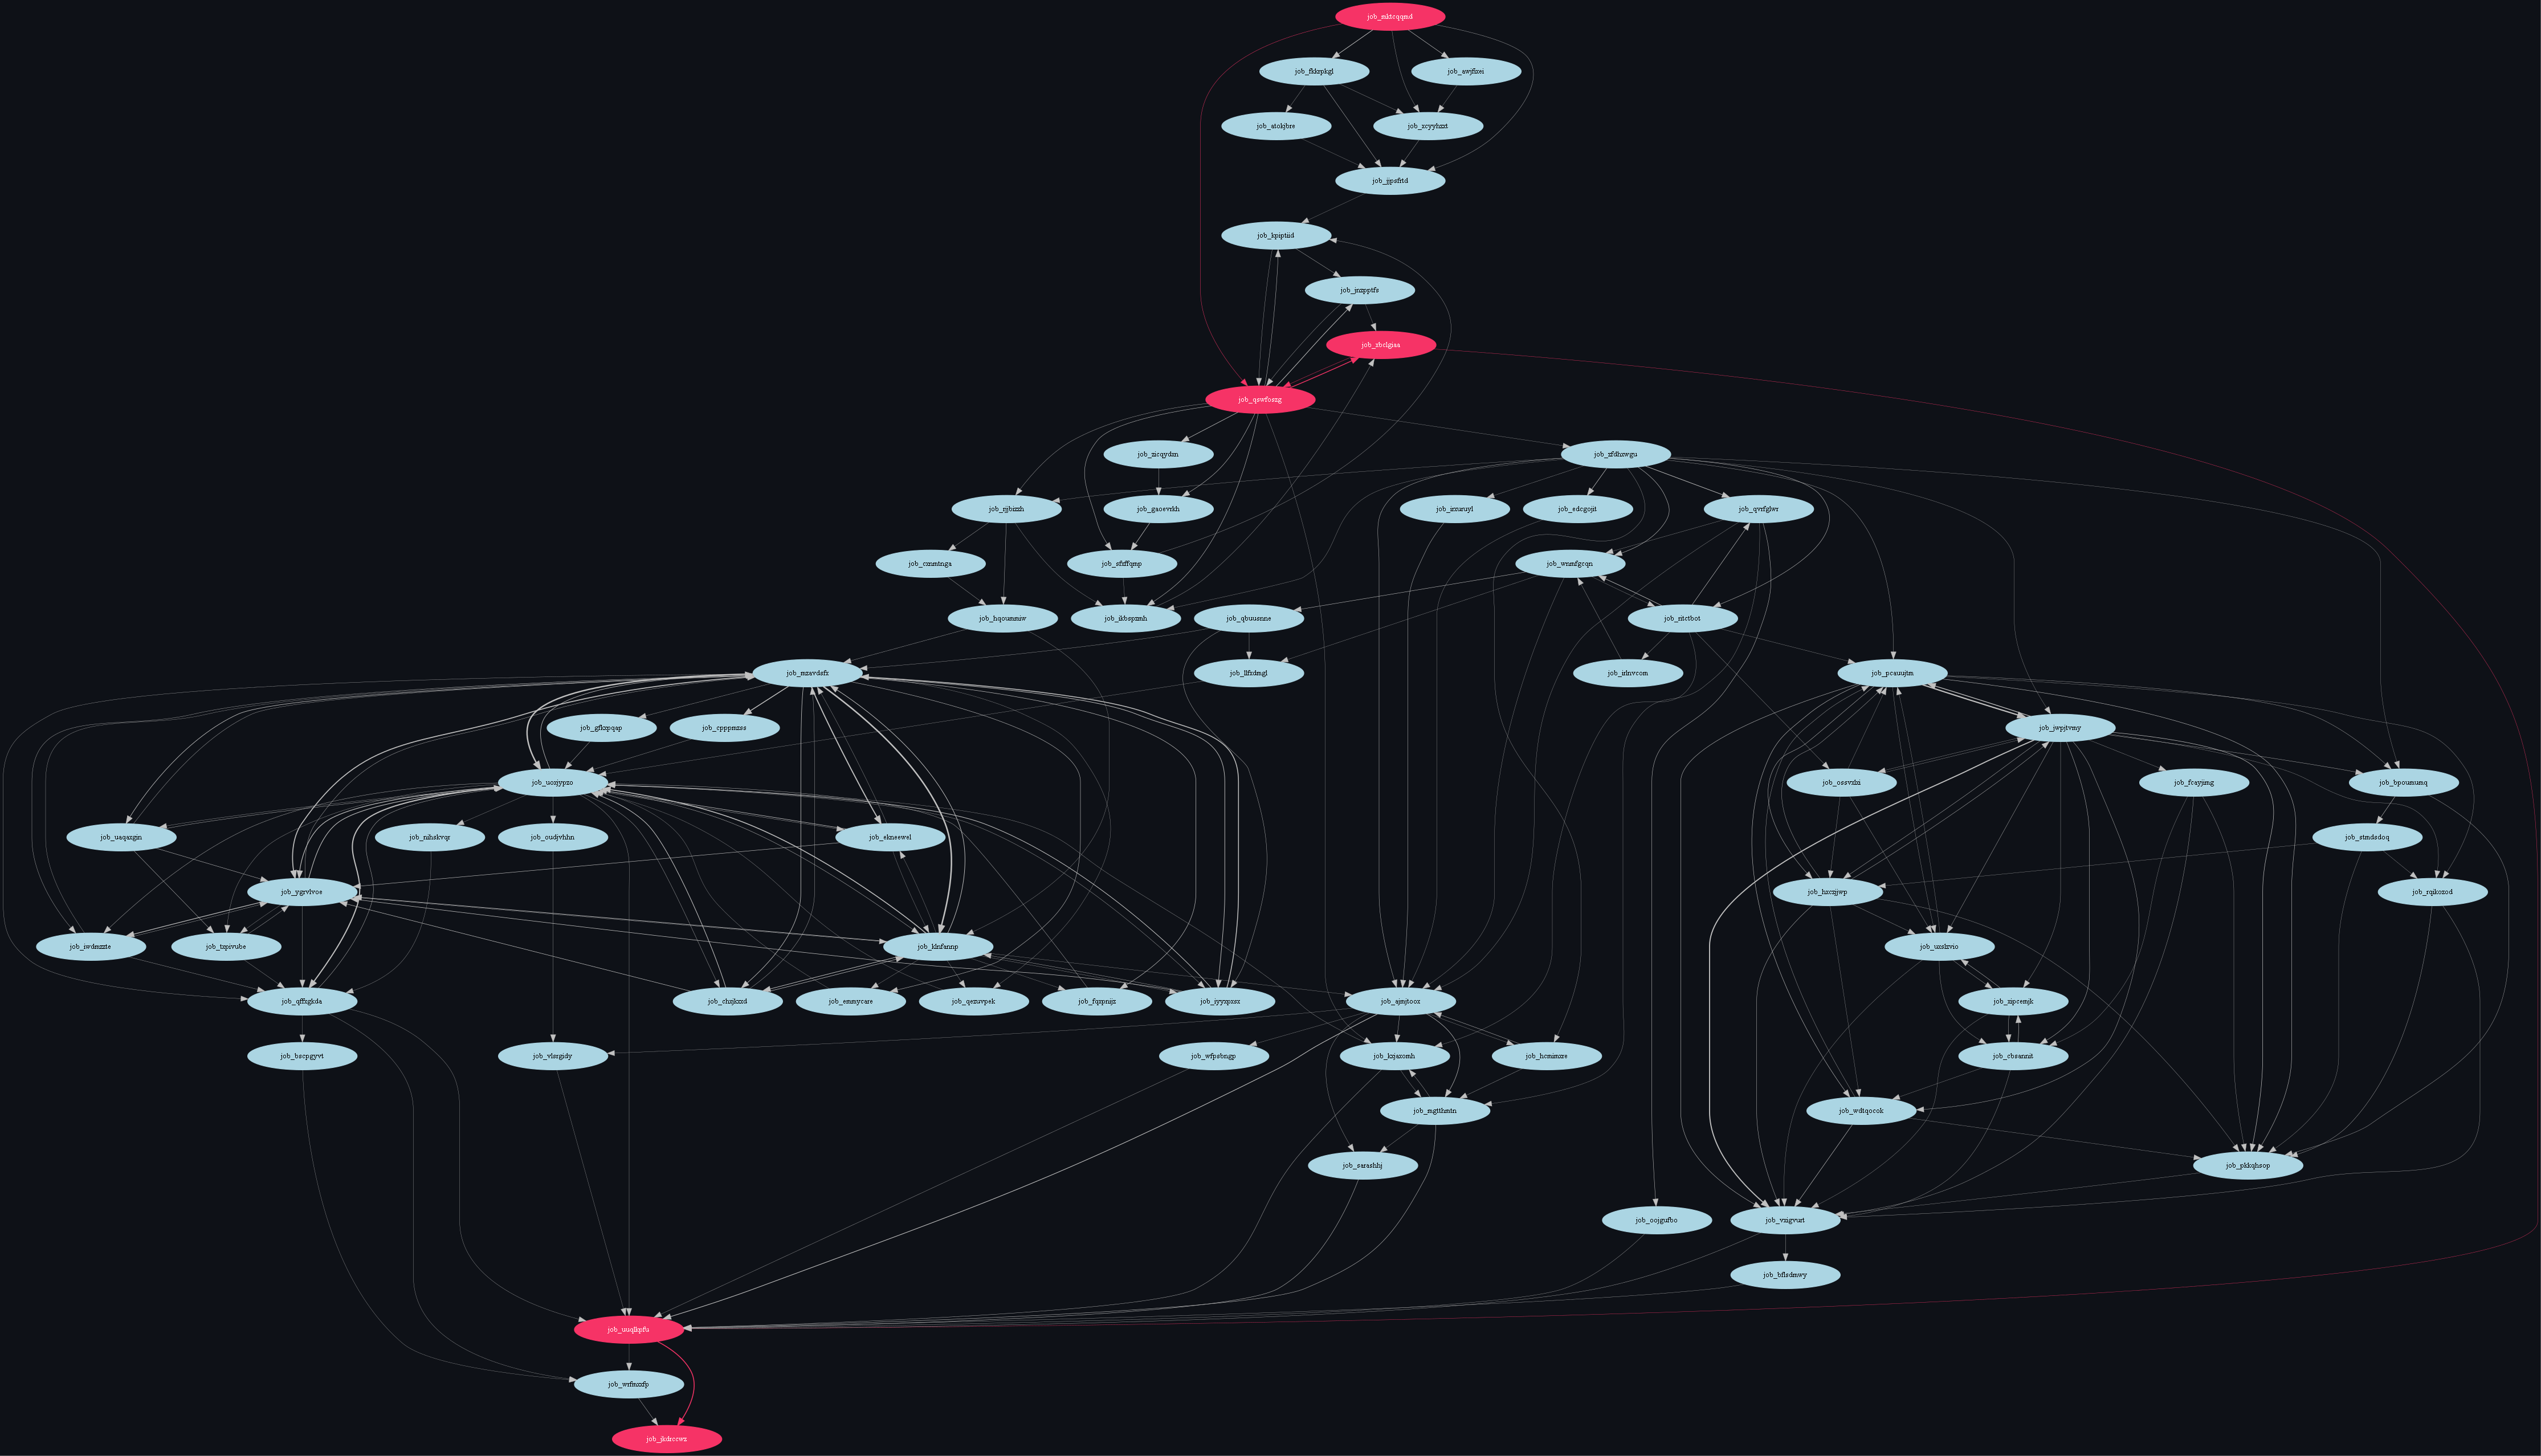

Optimal path ['job_mktcqqmd', 'job_qswfoszg', 'job_xbclgiaa', 'job_uuqlkpfu', 'job_jkdrccwz']


In [29]:
state_from = 'job_mktcqqmd'
state_to = 'job_jkdrccwz'
viz_paths(G, state_from, state_to, f'shortest path between {state_from} and {state_to}')